In [133]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import time
import json

from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#matplotlib.use('SVG') #set the backend to SVG

#Versioning
print('Pyhton Version: ', sys.version)
print('Pandas Version: ', pd.__version__)
print('Python Timestamp: ', time.asctime())

Pyhton Version:  3.7.3 (default, Mar 26 2019, 21:43:19) 
[GCC 8.2.1 20181127]
Pandas Version:  0.24.1
Python Timestamp:  Tue May  7 00:22:38 2019


In [134]:
# Parameterization
OWN_STOPWORDS_PATH = 'Data/OwnStopwords.csv'
BROWSER_HISTORY_PATH = 'Data/BrowserHistory_Simon.json'
YOUTUBE_VIEWS_PATH = 'Data/YoutubeViewhistory.json'
YOUTUBE_SEARCH_PATH = 'Data/YoutubeSearchhistory.json'
MASK_PATH = 'Data/mask_2.png'

START_DATE_FILTER = '01/01/2018' # Set to None for no time filter
END_DATE_FILTER = None
COLORMAP = 'hsv'


In [135]:
def load_search_data(path):    
    history_json = open(path)
    history_str = history_json.read()
    history = json.loads(history_str)
    
    history_df = pd.DataFrame(history['Browser History'])
    history_df.time_usec = pd.to_datetime(history_df.time_usec, unit='us')

    history_df = history_df.loc[:, ['title', 'page_transition', 'time_usec']]
    history_df = history_df.drop_duplicates(subset='title', keep='first', inplace=False)
    return history_df

def load_youtube_data(path_search, path_view, split=False):
    view_json, search_json = open(path_view), open(path_search)
    view_str, search_str = view_json.read(), search_json.read()
    view, search = json.loads(view_str), json.loads(search_str)
    
    search_df, view_df = pd.DataFrame(search), pd.DataFrame(view)
    return (search_df, view_df) if split else pd.concat([search_df, view_df], sort=False)

def load_additional_stopwords(path='Data/TopWebsites.csv'):
    # Load top websites for stopwords
    website_df = pd.read_csv(path)
    website_split_df = website_df['Name'].str.split('.',expand=True)
    #website_split_df[0].unique()
    #print(website_split_df.head())
    stopwords_website = np.concatenate((website_split_df[0].unique(), website_split_df[1].unique()), axis=0)
    return stopwords_website

def load_custom_stopwords(path):
    df = pd.read_csv(path)
    #print(df.head())
    return df['Name'].unique().tolist()

history_df, youtube_df = load_search_data(BROWSER_HISTORY_PATH), load_youtube_data(YOUTUBE_SEARCH_PATH, YOUTUBE_VIEWS_PATH)
stopwords_website = load_additional_stopwords()
stopwords_custom = load_custom_stopwords(OWN_STOPWORDS_PATH)
#print(history_df.page_transition.unique())
print(f'Browser/Youtube history length: {len(history_df)}|{len(youtube_df)}')
print('Cleaned browser history length: ', len(history_df))
#print(history_df.head())
#print(youtube_df.head())
#print(history_df.tail())

Browser/Youtube history length: 25887|544
Cleaned browser history length:  25887


WordCloud data word count:  25887


/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using svg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


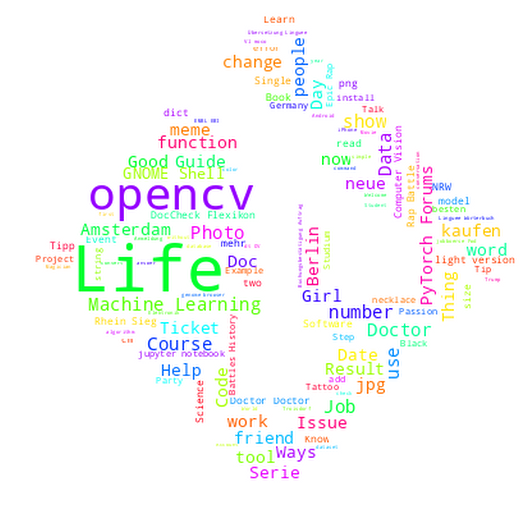

In [138]:
# Generate wordcloud
def render_wordcloud(data, add_stopwords=[], start_date=None, end_date=None, use_mask=False, w=800, h=400, save_img=False):
    background = 'white'
    font_size = 50
    scaling = 1.0
    words = 200
    fig_width, fig_width = 16, 9
    
    if start_date != None and end_date != None:
        mask = (data.time_usec > start_date) & (data.time_usec <= end_date)
        data = data[mask]
    wc_data = data.loc[:, 'title'].str.cat(sep=',')
    print('WordCloud data word count: ', len(data))

    stopwords = set(STOPWORDS)
    stopwords_de = get_stop_words('de')
    add_stopwords.append(stopwords_de)
    [stopwords.update(sw) for sw in add_stopwords]
    
    custom_mask = None
    if use_mask:
        custom_mask = np.array(Image.open(MASK_PATH))
    
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color=background, colormap=COLORMAP, max_font_size=font_size, min_font_size=4, max_words=words, width=w, height=h, mask=custom_mask, scale=scaling).generate(wc_data)
    
    # Display the generated wordcloud:
    #my_dpi = 100
    #fig = plt.figure(figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
   
    if save_img:
        #plt.imshow(wordcloud, interpolation='lanczos')
        #plt.savefig(f'Output/{int(time.time_ns() / 1e9)}_wordcloud.svg', bbox_inches='tight', dpi=800)
        #plt.close(fig)
        wordcloud.to_file(f'Output/{int(time.time_ns() / 1e9)}_wordcloud.png')
    else:
        fig = plt.gcf() #get current figure
        fig.set_size_inches(fig_width, fig_width)  
        plt.axis("off")
        plt.imshow(wordcloud, interpolation='lanczos')
        plt.show()
    
render_wordcloud(history_df, add_stopwords=[stopwords_website, stopwords_custom], use_mask=True, w=3200, h=1600, save_img=False)
#render_wordcloud(youtube_df, add_stopwords=[stopwords_website, stopwords_custom], use_mask=False, save_img=True)